## SPHEREx Concept



In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np 
import pandas as pd

np.random.seed(42)

from atm import __version__
print("ATM Version: {}".format(__version__))

ATM Version: 1.1.dev29+g06ebd70


In [2]:
SPHEREX_REPO = "Public-products"
if not os.path.exists(SPHEREX_REPO):
    ! git clone https://github.com/SPHEREx/Public-products

In [3]:
point_source = pd.read_csv(
    os.path.join(SPHEREX_REPO, "FWHM_v28_base_cbe.txt"), 
    index_col=None, 
    delim_whitespace=True,
    skiprows=1,
    names=[
        "lambda [mum]", 
        "FWHM [arsec]"
    ])

In [4]:
point_source["lambda [mum]"].values * 1e-6

array([7.500000e-07, 7.682927e-07, 7.870315e-07, 8.062274e-07,
       8.258915e-07, 8.460352e-07, 8.666702e-07, 8.878085e-07,
       9.094624e-07, 9.316444e-07, 9.543674e-07, 9.776447e-07,
       1.001490e-06, 1.025916e-06, 1.050939e-06, 1.076571e-06,
       1.137073e-06, 1.164807e-06, 1.193217e-06, 1.222319e-06,
       1.252132e-06, 1.282672e-06, 1.313957e-06, 1.346004e-06,
       1.378834e-06, 1.412464e-06, 1.446914e-06, 1.482205e-06,
       1.518356e-06, 1.555389e-06, 1.593325e-06, 1.632187e-06,
       1.680000e-06, 1.720976e-06, 1.762951e-06, 1.805949e-06,
       1.849997e-06, 1.895119e-06, 1.941341e-06, 1.988691e-06,
       2.037196e-06, 2.086883e-06, 2.137783e-06, 2.189924e-06,
       2.243337e-06, 2.298052e-06, 2.354102e-06, 2.411520e-06,
       2.489143e-06, 2.560261e-06, 2.633412e-06, 2.708652e-06,
       2.786042e-06, 2.865643e-06, 2.947519e-06, 3.031733e-06,
       3.118354e-06, 3.207450e-06, 3.299092e-06, 3.393351e-06,
       3.490304e-06, 3.590027e-06, 3.692600e-06, 3.7981

In [5]:
import sys
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from atm.models import STM, FRM, NEATM
from atm.obs import SPHEREx
from atm import fit
from atm import modifyErrors

# Additonal imports to make simulated data
from atm import Config
from atm.functions import calcTss, calcQ
from atm.functions import interpFluxLambdaObsWithSunlight
from atm.functions import calcFluxLambdaObsWithSunlight
from atm.functions import calcFluxLambdaAtObsWithSunlight
from atm.functions import calcFluxLambdaSED
from atm.plotting import plotObservations, plotSED

%matplotlib inline

In [6]:
DPI = 300
SAVE_DIR = "/spherex/"
FORMAT = "png"

SAVE_FIGS = False

In [7]:
m_to_mum = 1e6 # simple conversion from m to micron
km_to_m = 1e3 # conversion km to m

In [8]:
# Instantiate observatory and NEATM class for simulating data
obs = SPHEREx()
model = NEATM(verbose=False)

In [9]:
# Load SPHEREx quadrature lookup tables into memory 
model.loadLambdaTables(obs.filterQuadratureLambdas, verbose=False)

In [10]:
files = glob.glob("*SPHERExSED.dat")
sigma = 0.2

no_sigma_data_dfs = []
with_sigma_data_dfs = []

columnMapping = {
    "designation" : "designation",
    "obs_id" : "obs_id",
    "r_au" : "r",
    "delta_au" : "delta",
    "alpha_rad" : "alpha",
    "G" : "G",
    "logT1" : "logT1",
    "logD": "logD",
    "eps" : "eps", 
    "flux_si": ["flux_{}_si".format(i) for i in obs.filterNames],
    "fluxErr_si": ["fluxErr_{}_si".format(i) for i in obs.filterNames],
    "mag" : ["mag_{}_AB".format(i) for i in obs.filterNames],
    "magErr" : ["magErr_{}_AB".format(i) for i in obs.filterNames],
}

for i, file in enumerate(sorted(files)):
    wavelength, mag, magErr, epsilon, albedo = np.loadtxt(file)

    f_split = file.split("_")
    
    r = float(f_split[3][1:])
    d = float(f_split[4][1:])
    t1 = float(f_split[2][1:])
    eps = float(f_split[1][1:])
    
    data = {
        "designation" : ["_".join(f_split[1:5])],
        "obs_id" : [i + 1],
        "r" : [r],
        "delta" : [r - 1],
        "alpha" : [0],
        "logD" : np.log10([d * 1000]),
        "logT1" : np.log10([t1]),
        "eps" : [eps],
        "G" : [0.15],
    }
    flambda = obs.convertMagToFluxLambda(mag)
    flambdaerr = obs.convertMagErrToFluxLambdaErr(mag, magErr)
    for i, (mag_i, magErr_i) in enumerate(zip(mag, magErr)):
        filter_i = obs.filterNames[i]
        data["flux_{}_si".format(filter_i)] = flambda[i]
        data["fluxErr_{}_si".format(filter_i)] = flambdaerr[i]
        data["mag_{}_AB".format(filter_i)] = np.array([mag_i])
        data["magErr_{}_AB".format(filter_i)] = np.array([magErr_i])
        
    no_sigma = pd.DataFrame(data)
    no_sigma_data_dfs.append(no_sigma)
    
    # Add rotational sigmas
    with_sigma = modifyErrors(no_sigma.copy(), obs, sigma=sigma, columnMapping=columnMapping)
    for f in obs.filterNames:
        with_sigma.loc[:, "mag_{}_AB".format(f)] += np.random.normal(loc=0.0, scale=sigma)

    mags = with_sigma[["mag_{}_AB".format(f) for f in obs.filterNames]].values
    fluxes = obs.convertMagToFluxLambda(mags)
    with_sigma[["flux_{}_si".format(f) for f in obs.filterNames]] = fluxes
    with_sigma_data_dfs.append(with_sigma)

    
data_no_sigma = pd.concat(no_sigma_data_dfs)
data_with_sigma = pd.concat(with_sigma_data_dfs)
for df in [data_no_sigma, data_with_sigma]:
    df.reset_index(
        inplace=True, 
        drop=True
    )

In [11]:
data_no_sigma

,designation,obs_id,r,delta,alpha,logD,logT1,eps,G,flux_s01_si,...,mag_s94_AB,magErr_s94_AB,flux_s95_si,fluxErr_s95_si,mag_s95_AB,magErr_s95_AB,flux_s96_si,fluxErr_s96_si,mag_s96_AB,magErr_s96_AB
0,E0.94_T400_r2.5_D10.0,1,2.5,1.5,0,4.000000,2.60206,0.94,0.15,1.549997e-08,...,15.485747,0.055535,2.999305e-10,1.527244e-11,15.422859,0.055286,3.295048e-10,1.670512e-11,15.304116,0.055044
1,E0.94_T400_r2.5_D3.0,2,2.5,1.5,0,3.477121,2.60206,0.94,0.15,1.385621e-09,...,18.036602,0.249452,2.888926e-11,6.471105e-12,17.963569,0.243202,3.789999e-11,8.274012e-12,17.652173,0.237029
2,E0.98_T400_r3.0_D17.0,3,3.0,2.0,0,4.230449,2.60206,0.98,0.15,6.634672e-09,...,16.383793,0.067742,1.415339e-10,8.689866e-12,16.238259,0.066662,1.564986e-10,9.460807e-12,16.112495,0.065636
3,E0.98_T400_r3.0_D5.0,4,3.0,2.0,0,3.698970,2.60206,0.98,0.15,5.452311e-10,...,18.569406,0.504898,1.135958e-11,5.088326e-12,18.977005,0.486337,1.477146e-11,6.371958e-12,18.675212,0.468353


In [12]:
data_with_sigma

,designation,obs_id,r,delta,alpha,logD,logT1,eps,G,flux_s01_si,...,mag_s94_AB,magErr_s94_AB,flux_s95_si,fluxErr_s95_si,mag_s95_AB,magErr_s95_AB,flux_s96_si,fluxErr_s96_si,mag_s96_AB,magErr_s96_AB
0,E0.94_T400_r2.5_D10.0,1,2.5,1.5,0,4.000000,2.60206,0.94,0.15,1.414470e-08,...,15.420215,0.255535,3.223957e-10,7.052168e-11,15.344437,0.255286,4.314623e-10,7.740214e-11,15.011413,0.255044
1,E0.94_T400_r2.5_D3.0,2,2.5,1.5,0,3.477121,2.60206,0.94,0.15,1.312064e-09,...,17.733632,0.449452,3.136589e-11,1.179270e-11,17.874266,0.443202,3.236885e-11,1.525545e-11,17.823453,0.437029
2,E0.98_T400_r3.0_D17.0,3,3.0,2.0,0,4.230449,2.60206,0.98,0.15,6.378110e-09,...,15.993375,0.267742,1.455470e-10,3.476137e-11,16.207902,0.266662,1.404252e-10,3.828891e-11,16.230158,0.265636
3,E0.98_T400_r3.0_D5.0,4,3.0,2.0,0,3.698970,2.60206,0.98,0.15,5.177276e-10,...,18.449527,0.704898,1.679863e-11,7.180838e-12,18.552226,0.686337,1.627361e-11,9.092963e-12,18.570061,0.668353


Calculating number of fits to run...
Fit code: run1_noSigma
Number of fits to run: 4

Fit code: run2_noSigma
Number of fits to run: 4

Fit code: run3_noSigma
Number of fits to run: 4

Fit code: run1_withSigma
Number of fits to run: 4

Fit code: run2_withSigma
Number of fits to run: 4

Fit code: run3_withSigma
Number of fits to run: 4

Total number of fits to run: 24

Starting fit code: run1_noSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 1/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run1_noSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:24<00:00, 2414.90draws/s]


Found best fit parameters:
 logT1: 2.602 +- 0.001
 logD:  4.001 +- 0.001
Total time: 107.41 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_noSigma/atm_results_run1_noSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 2/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run1_noSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:26<00:00, 2239.42draws/s]


Found best fit parameters:
 logT1: 2.598 +- 0.003
 logD:  3.478 +- 0.002
Total time: 106.56 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_noSigma/atm_results_run1_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 3/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run1_noSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2217.62draws/s]


Found best fit parameters:
 logT1: 2.602 +- 0.001
 logD:  4.229 +- 0.001
Total time: 105.56 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_noSigma/atm_results_run1_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 4/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run1_noSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2214.10draws/s]


Found best fit parameters:
 logT1: 2.595 +- 0.006
 logD:  3.691 +- 0.004
Total time: 105.11 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_noSigma/atm_results_run1_noSigma.db)...
Done.

Starting fit code: run2_noSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 5/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run2_noSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['eps', 'logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:38<00:00, 1543.41draws/s]


Found best fit parameters:
 logT1: 2.672 +- 0.008
 logD:  3.643 +- 0.029
 eps:   0.691 +- 0.040
Total time: 120.30 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_noSigma/atm_results_run2_noSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 6/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run2_noSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['eps', 'logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:39<00:00, 1533.87draws/s]


Found best fit parameters:
 logT1: 2.663 +- 0.012
 logD:  3.136 +- 0.049
 eps:   0.711 +- 0.066
Total time: 122.31 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_noSigma/atm_results_run2_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 7/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run2_noSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['eps', 'logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:41<00:00, 1432.62draws/s]


Found best fit parameters:
 logT1: 2.705 +- 0.006
 logD:  3.647 +- 0.025
 eps:   0.711 +- 0.033
Total time: 125.50 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_noSigma/atm_results_run2_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 8/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run2_noSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['eps', 'logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:42<00:00, 1426.75draws/s]


Found best fit parameters:
 logT1: 2.689 +- 0.019
 logD:  3.125 +- 0.081
 eps:   0.728 +- 0.106
Total time: 123.07 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_noSigma/atm_results_run2_noSigma.db)...
Done.

Starting fit code: run3_noSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 9/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run3_noSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's5

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:49<00:00, 1220.98draws/s]


Found best fit parameters:
 logT1:  2.676 +- 0.007
 logD:   3.632 +- 0.028
 eps_S1: 0.671 +- 0.042
 eps_S2: 0.703 +- 0.036
Total time: 132.56 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_noSigma/atm_results_run3_noSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 10/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run3_noSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55'], dt

Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps_S2]
INFO:pymc3:>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
INFO:pymc3:>Metropolis: [eps_S1]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:55<00:00, 1086.18draws/s]


Found best fit parameters:
 logT1:  2.665 +- 0.010
 logD:   3.132 +- 0.037
 eps_S1: 0.704 +- 0.050
 eps_S2: 0.725 +- 0.047
Total time: 140.18 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_noSigma/atm_results_run3_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 11/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run3_noSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55'], 

Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps_S2]
INFO:pymc3:>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
INFO:pymc3:>Metropolis: [eps_S1]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:56<00:00, 1065.92draws/s]


Found best fit parameters:
 logT1:  2.711 +- 0.009
 logD:   3.626 +- 0.036
 eps_S1: 0.678 +- 0.053
 eps_S2: 0.711 +- 0.044
Total time: 142.95 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_noSigma/atm_results_run3_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 12/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run3_noSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55'], dt

Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps_S2]
INFO:pymc3:>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
INFO:pymc3:>Metropolis: [eps_S1]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:55<00:00, 1084.46draws/s]


Found best fit parameters:
 logT1:  2.695 +- 0.023
 logD:   3.100 +- 0.092
 eps_S1: 0.695 +- 0.133
 eps_S2: 0.721 +- 0.118
Total time: 141.92 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_noSigma/atm_results_run3_noSigma.db)...
Done.

Starting fit code: run1_withSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 13/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run1_withSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2204.17draws/s]


Found best fit parameters:
 logT1: 2.601 +- 0.003
 logD:  4.008 +- 0.006
Total time: 106.08 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_withSigma/atm_results_run1_withSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 14/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run1_withSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:28<00:00, 2090.04draws/s]


Found best fit parameters:
 logT1: 2.596 +- 0.006
 logD:  3.481 +- 0.007
Total time: 107.56 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_withSigma/atm_results_run1_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 15/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run1_withSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:28<00:00, 2140.36draws/s]


Found best fit parameters:
 logT1: 2.604 +- 0.003
 logD:  4.230 +- 0.006
Total time: 107.22 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_withSigma/atm_results_run1_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 16/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run1_withSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2186.02draws/s]


Found best fit parameters:
 logT1: 2.595 +- 0.009
 logD:  3.684 +- 0.010
Total time: 106.23 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_withSigma/atm_results_run1_withSigma.db)...
Done.

Starting fit code: run2_withSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 17/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run2_withSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['eps', 'logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps]
INFO:pymc3:>Metropolis: [eps]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:41<00:00, 1445.78draws/s]


Found best fit parameters:
 logT1: 2.661 +- 0.020
 logD:  3.690 +- 0.082
 eps:   0.743 +- 0.100
Total time: 121.27 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_withSigma/atm_results_run2_withSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 18/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run2_withSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['eps', 'logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps]
INFO:pymc3:>Metropolis: [eps]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:42<00:00, 1397.51draws/s]


Found best fit parameters:
 logT1: 2.665 +- 0.030
 logD:  3.119 +- 0.117
 eps:   0.684 +- 0.171
Total time: 122.58 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_withSigma/atm_results_run2_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 19/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run2_withSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['eps', 'logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps]
INFO:pymc3:>Metropolis: [eps]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:40<00:00, 1497.89draws/s]


Found best fit parameters:
 logT1: 2.707 +- 0.025
 logD:  3.646 +- 0.102
 eps:   0.711 +- 0.132
Total time: 119.44 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_withSigma/atm_results_run2_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 20/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run2_withSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['eps', 'logD', 'logT1']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps]
INFO:pymc3:>Metropolis: [eps]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:39<00:00, 1513.34draws/s]


Found best fit parameters:
 logT1: 2.685 +- 0.046
 logD:  3.083 +- 0.173
 eps:   0.683 +- 0.258
Total time: 119.25 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_withSigma/atm_results_run2_withSigma.db)...
Done.

Starting fit code: run3_withSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 21/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run3_withSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
 

Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps_S2]
INFO:pymc3:>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
INFO:pymc3:>Metropolis: [eps_S1]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:53<00:00, 1115.72draws/s]
/home/moeyensj/software/anaconda3/envs/atm_py38/lib/python3.8/site-packages/corner/corner.py:271: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


Found best fit parameters:
 logT1:  2.682 +- 0.020
 logD:   3.610 +- 0.076
 eps_S1: 0.621 +- 0.130
 eps_S2: 0.687 +- 0.102
Total time: 138.15 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_withSigma/atm_results_run3_withSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 22/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run3_withSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55

Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps_S2]
INFO:pymc3:>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
INFO:pymc3:>Metropolis: [eps_S1]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:51<00:00, 1173.00draws/s]


Found best fit parameters:
 logT1:  2.671 +- 0.029
 logD:   3.111 +- 0.110
 eps_S1: 0.666 +- 0.182
 eps_S2: 0.715 +- 0.144
Total time: 135.19 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_withSigma/atm_results_run3_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 23/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run3_withSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's

Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps_S2]
INFO:pymc3:>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
INFO:pymc3:>Metropolis: [eps_S1]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:53<00:00, 1121.62draws/s]


Found best fit parameters:
 logT1:  2.721 +- 0.025
 logD:   3.591 +- 0.094
 eps_S1: 0.620 +- 0.156
 eps_S2: 0.678 +- 0.123
Total time: 138.22 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_withSigma/atm_results_run3_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 24/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run3_withSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55

Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps_S2]
INFO:pymc3:>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
INFO:pymc3:>Metropolis: [eps_S1]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:53<00:00, 1125.52draws/s]


Found best fit parameters:
 logT1:  2.672 +- 0.738
 logD:   3.035 +- 0.135
 eps_S1: 0.606 +- 0.250
 eps_S2: 0.564 +- 0.275
Total time: 139.80 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_withSigma/atm_results_run3_withSigma.db)...
Done.



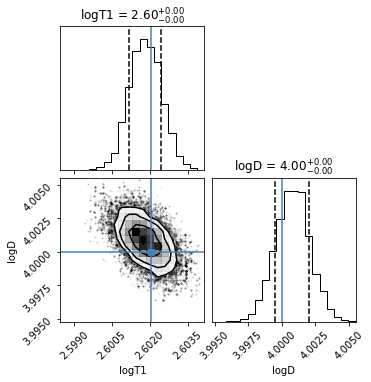

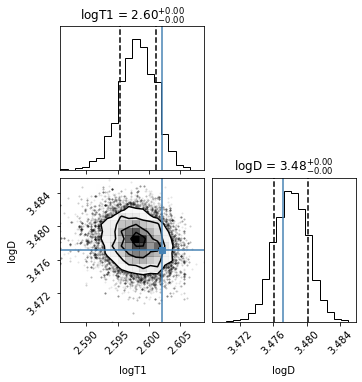

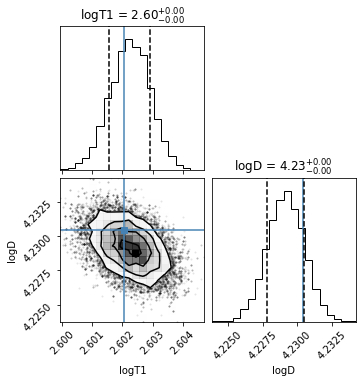

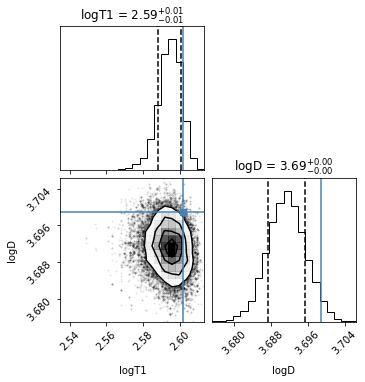

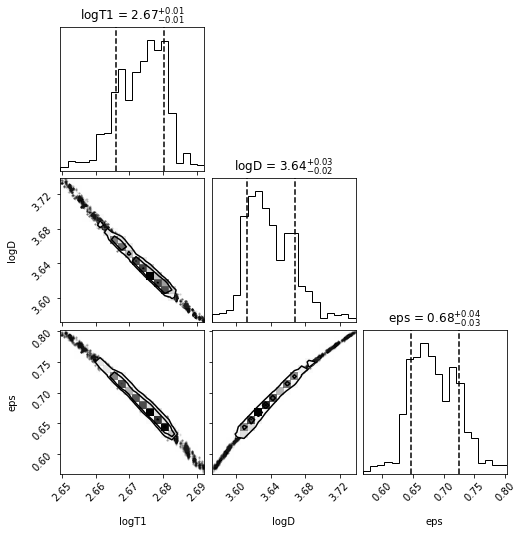

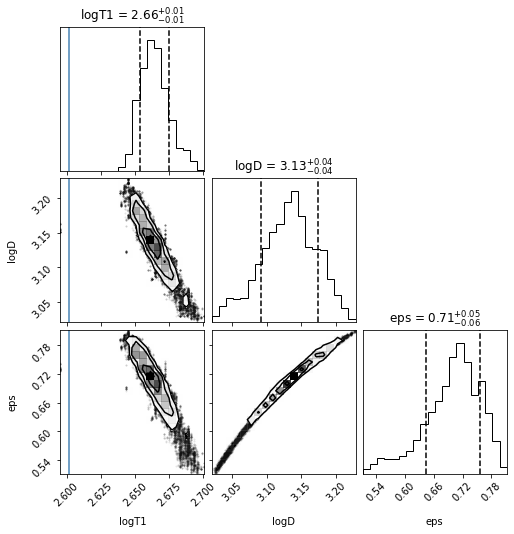

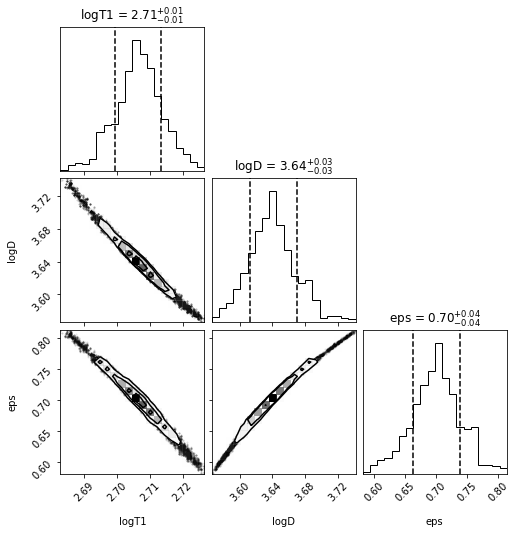

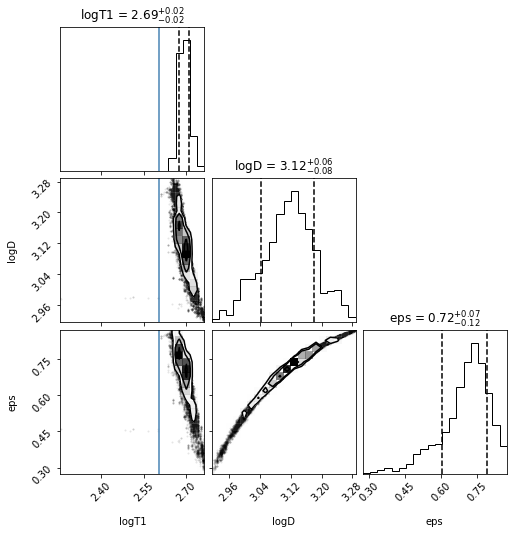

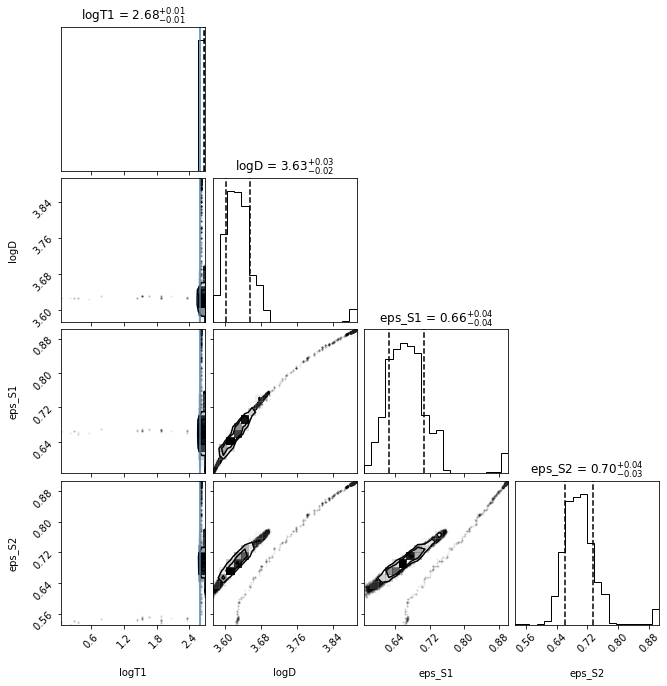

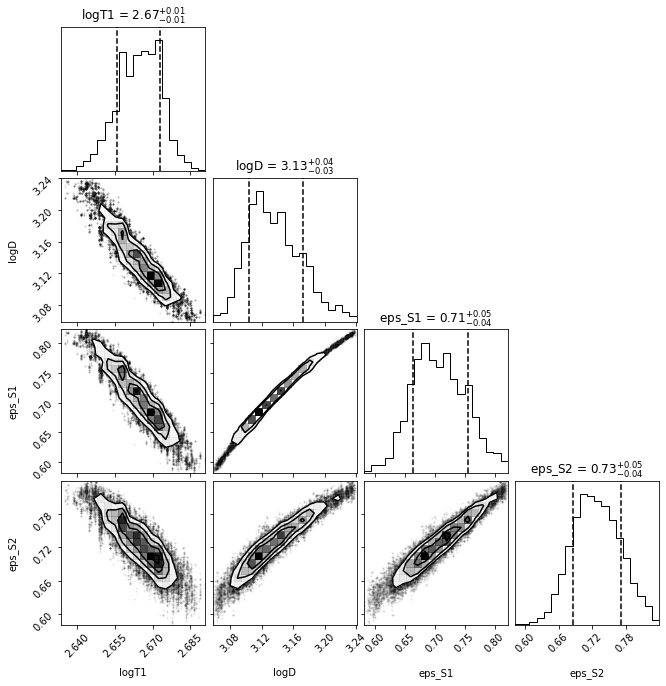

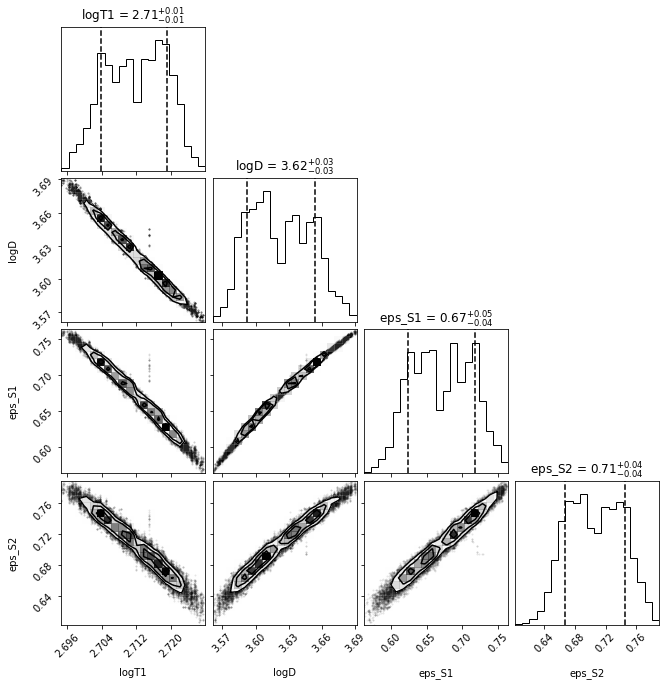

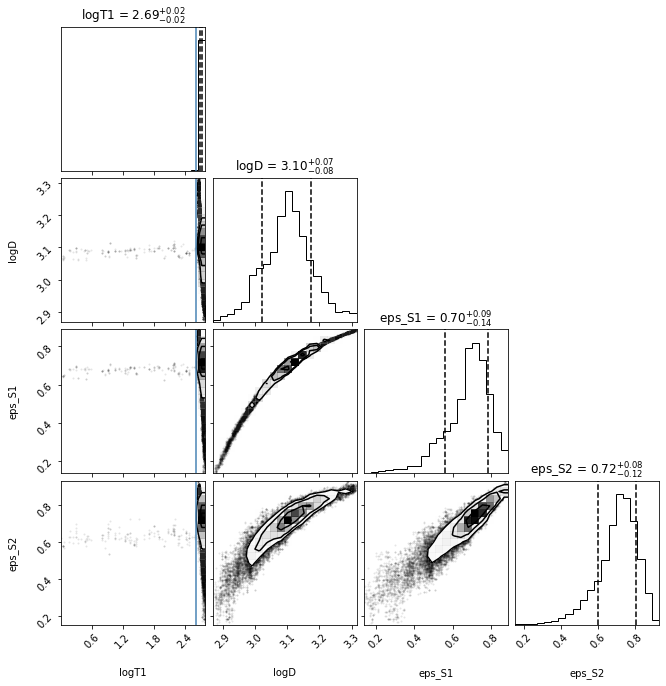

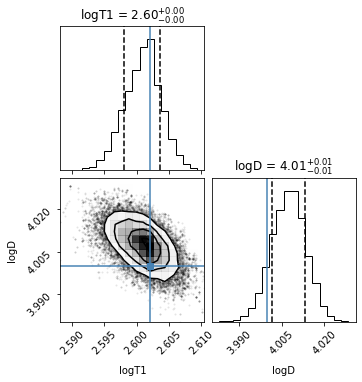

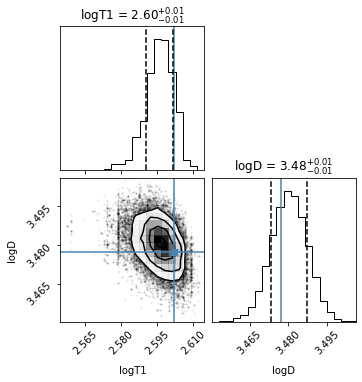

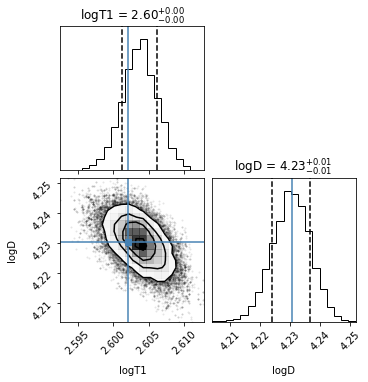

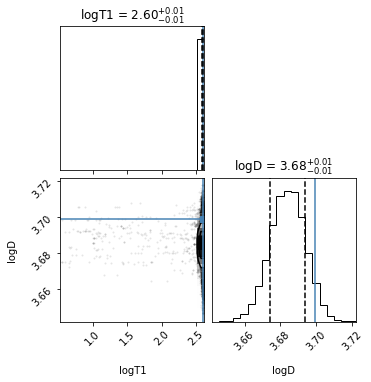

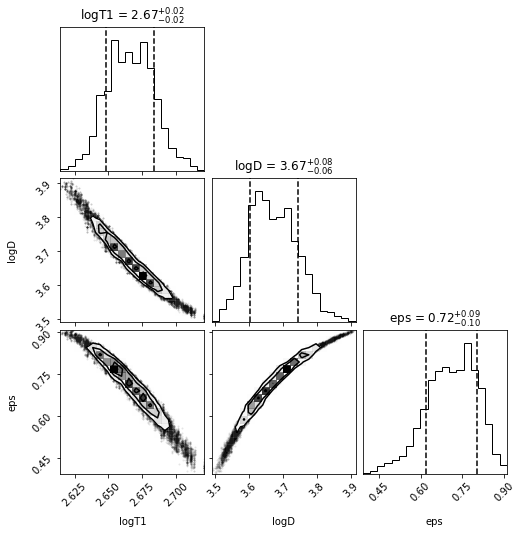

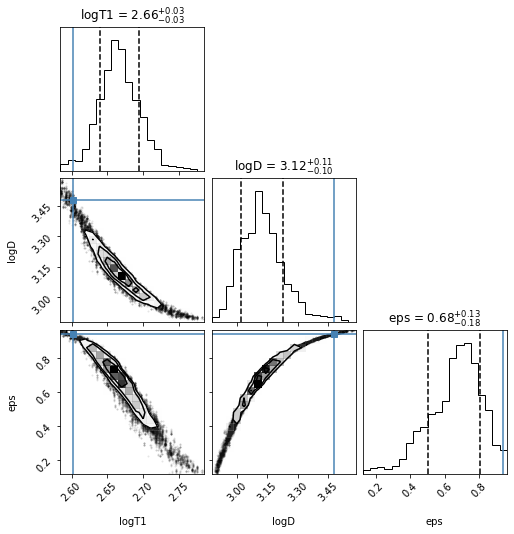

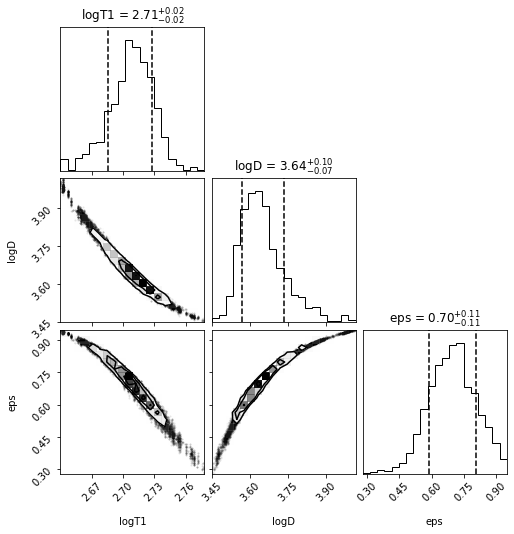

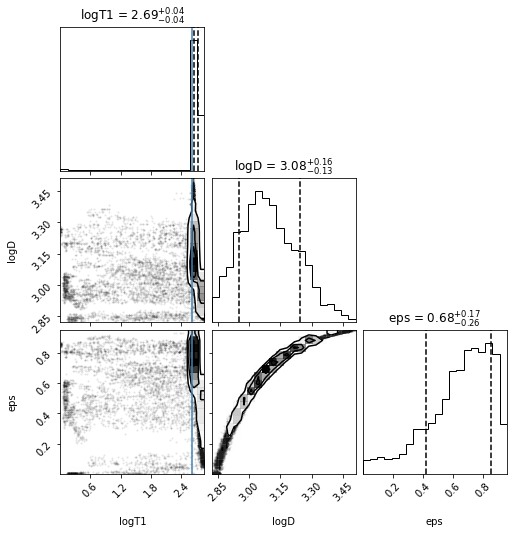

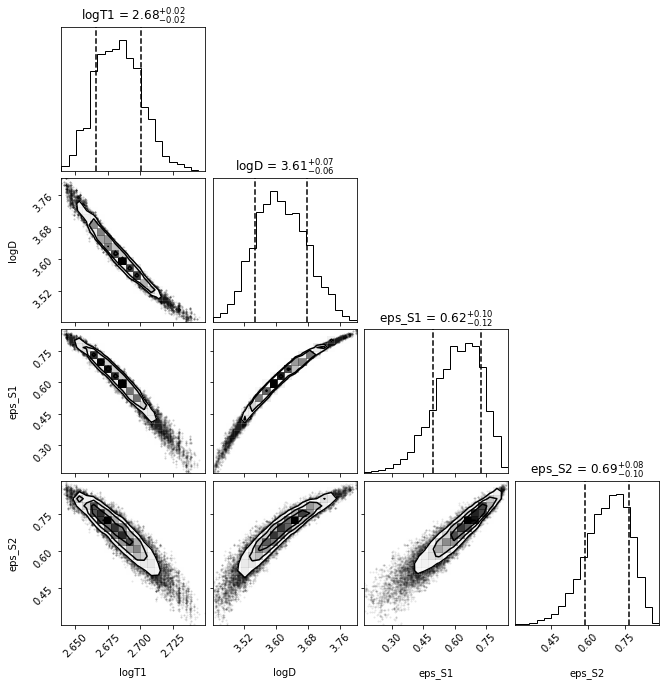

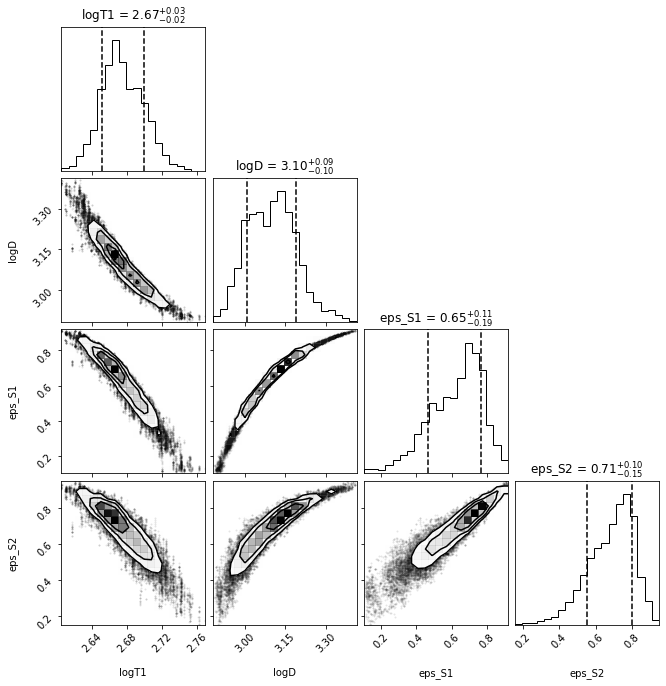

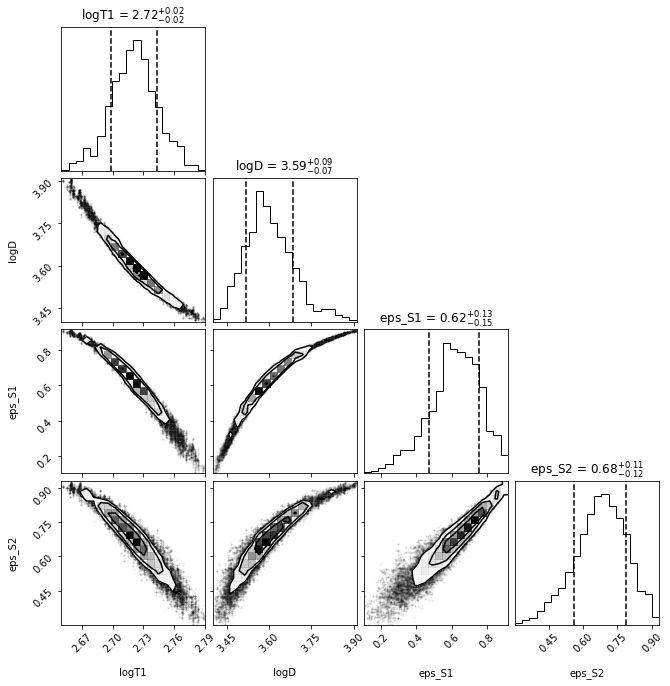

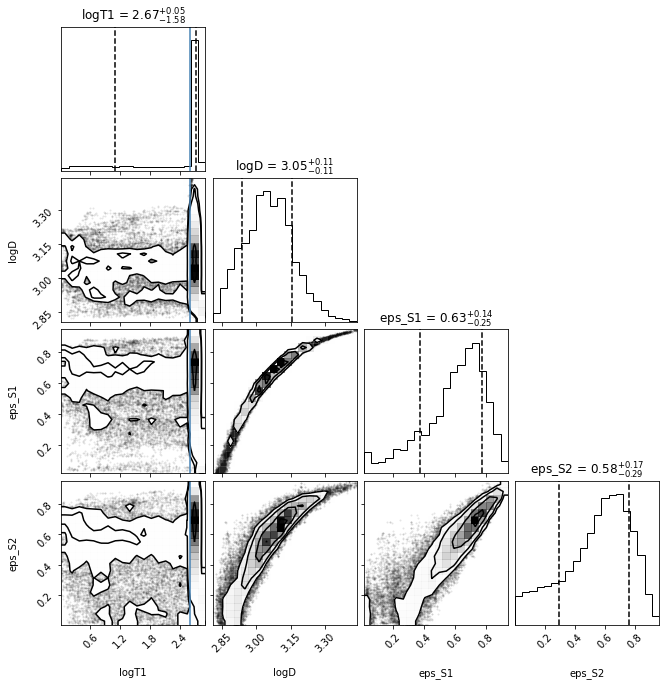

In [13]:
from atm import multiFit

# Initialize data dictionary
dataDict = {}
dataDict["run1_noSigma"] = data_no_sigma.copy()
dataDict["run2_noSigma"] = data_no_sigma.copy()
dataDict["run3_noSigma"] = data_no_sigma.copy()
dataDict["run1_withSigma"] = data_with_sigma.copy()
dataDict["run2_withSigma"] = data_with_sigma.copy()
dataDict["run3_withSigma"] = data_with_sigma.copy()

# Initialize fit dictionary
fitDict = {}
fitDict["run1_noSigma"] = {
    "fitParameters" : ["logT1", "logD"],
    "emissivitySpecification" : None,
    "albedoSpecification": "auto",
    "fitFilters" : "all",
    "columnMapping" : columnMapping
}

fitDict["run2_noSigma"] = {
    "fitParameters" : ["logT1", "logD", "eps"],
    "emissivitySpecification" : None,
    "albedoSpecification": "auto",
    "fitFilters" : "all",
    "columnMapping" : columnMapping
}

lambda_split = 3e-6
fitDict["run3_noSigma"] = {
    "fitParameters" : ["logT1", "logD", "eps_S1", "eps_S2"],
    "emissivitySpecification" : {
        "eps_S1" : np.array(obs.filterNames)[np.where(obs.filterEffectiveLambdas < lambda_split)],
        "eps_S2" : np.array(obs.filterNames)[np.where(obs.filterEffectiveLambdas >= lambda_split)]
    },
    "albedoSpecification": "auto",
    "fitFilters" : "all",
    "columnMapping" : columnMapping
}

fitDict["run1_withSigma"] = fitDict["run1_noSigma"]
fitDict["run2_withSigma"] = fitDict["run2_noSigma"]
fitDict["run3_withSigma"] = fitDict["run3_noSigma"]


# Set fit configuration
fitConfigDict = {
    "chains" : 30,
    "samples" : 1500,
    "burnInSamples": 500,
    "threads": 30,
    "scaling": 0.01,
    "plotTrace" : False,
    "plotCorner" : True,
    "progressBar" : True,
}

summary, model_observations = multiFit(
    model, 
    obs, 
    dataDict, 
    fitDict, 
    fitConfigDict, 
    saveDir="spherex"
)

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55'], dtype='<U3'), 'eps_S2': array(['s56', 's57', 's58', 's59', 's60', 's61', 's62', 's63', 's64',
       's65', 's66', 's67', 's68', 's69', 's70', 's71', 's72', 's73',
       's74', 's75', 's76', 's77', 's78', 's79', 's80', 's81', 's82',
       's83', 's84', 's85', 's86', 's87', 's88', 's89', 's90', 's91',
       's92', 's93', 's94', 's95', 's96'], dtype='<U3')}
Albedo Paramet

Multiprocess sampling (30 chains in 30 jobs)
INFO:pymc3:Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps_S2]
INFO:pymc3:>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
INFO:pymc3:>Metropolis: [eps_S1]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:56<00:00, 1067.77draws/s]


Found best fit parameters:
 logT1:  2.682 +- 0.021
 logD:   3.614 +- 0.077
 eps_S1: 0.628 +- 0.133
 eps_S2: 0.688 +- 0.106
Total time: 141.68 seconds
Done.



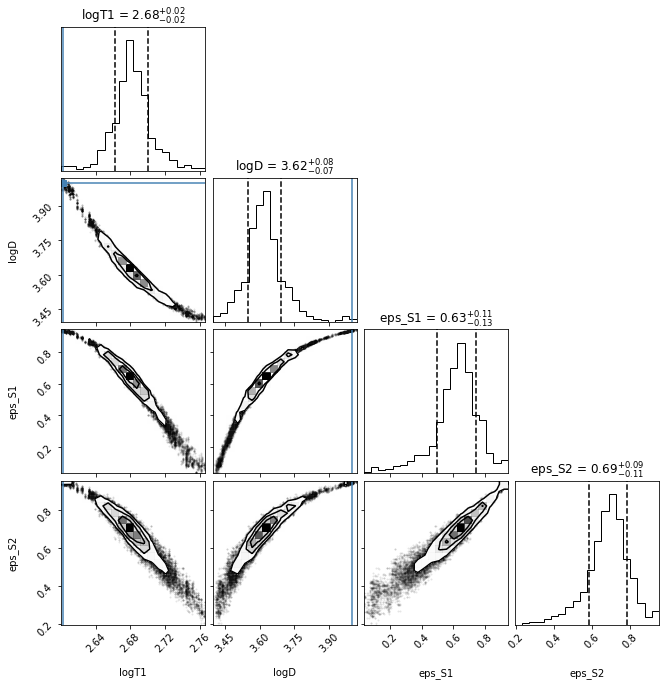

In [14]:
# This runs the fitter again, results can also be read from the databases created in the 
# previous cell
pick_run = "run3_withSigma"
pick_asteroid = 0 # 0 indexed

# Run NEATM
model = NEATM(verbose=False)
summary_neatm, model_observations_neatm, pymc_objs_neatm, figs = fit(
    model, 
    obs, 
    dataDict[pick_run][pick_asteroid:pick_asteroid+1],
    returnFigs=True,
    verbose=False,
    **fitDict[pick_run],
    **fitConfigDict
)

In [15]:
# Wavelength config for calculating SEDs
lambdaRange=[obs.filterQuadratureLambdas[0], obs.filterQuadratureLambdas[-1]]
lambdaNum=250

# For run 3s (comment/uncomment)
lambdaEdges=[obs.filterQuadratureLambdas[0], lambda_split, obs.filterQuadratureLambdas[-1]]
# For run 1 and 2 (comment/uncomment)
# lambdaEdges = None
linearInterpolation=False

SED_neatm_fit = calcFluxLambdaSED(
    model, 
    obs, 
    dataDict[pick_run][pick_asteroid:pick_asteroid+1],
    summary=summary_neatm,
    fitParameters=fitDict[pick_run]["fitParameters"],
    emissivitySpecification=fitDict[pick_run]["emissivitySpecification"],
    albedoSpecification=fitDict[pick_run]["albedoSpecification"],
    columnMapping=fitDict[pick_run]["columnMapping"],
    lambdaRange=lambdaRange,
    lambdaNum=lambdaNum,
    lambdaEdges=lambdaEdges,
    linearInterpolation=linearInterpolation,
  
)       

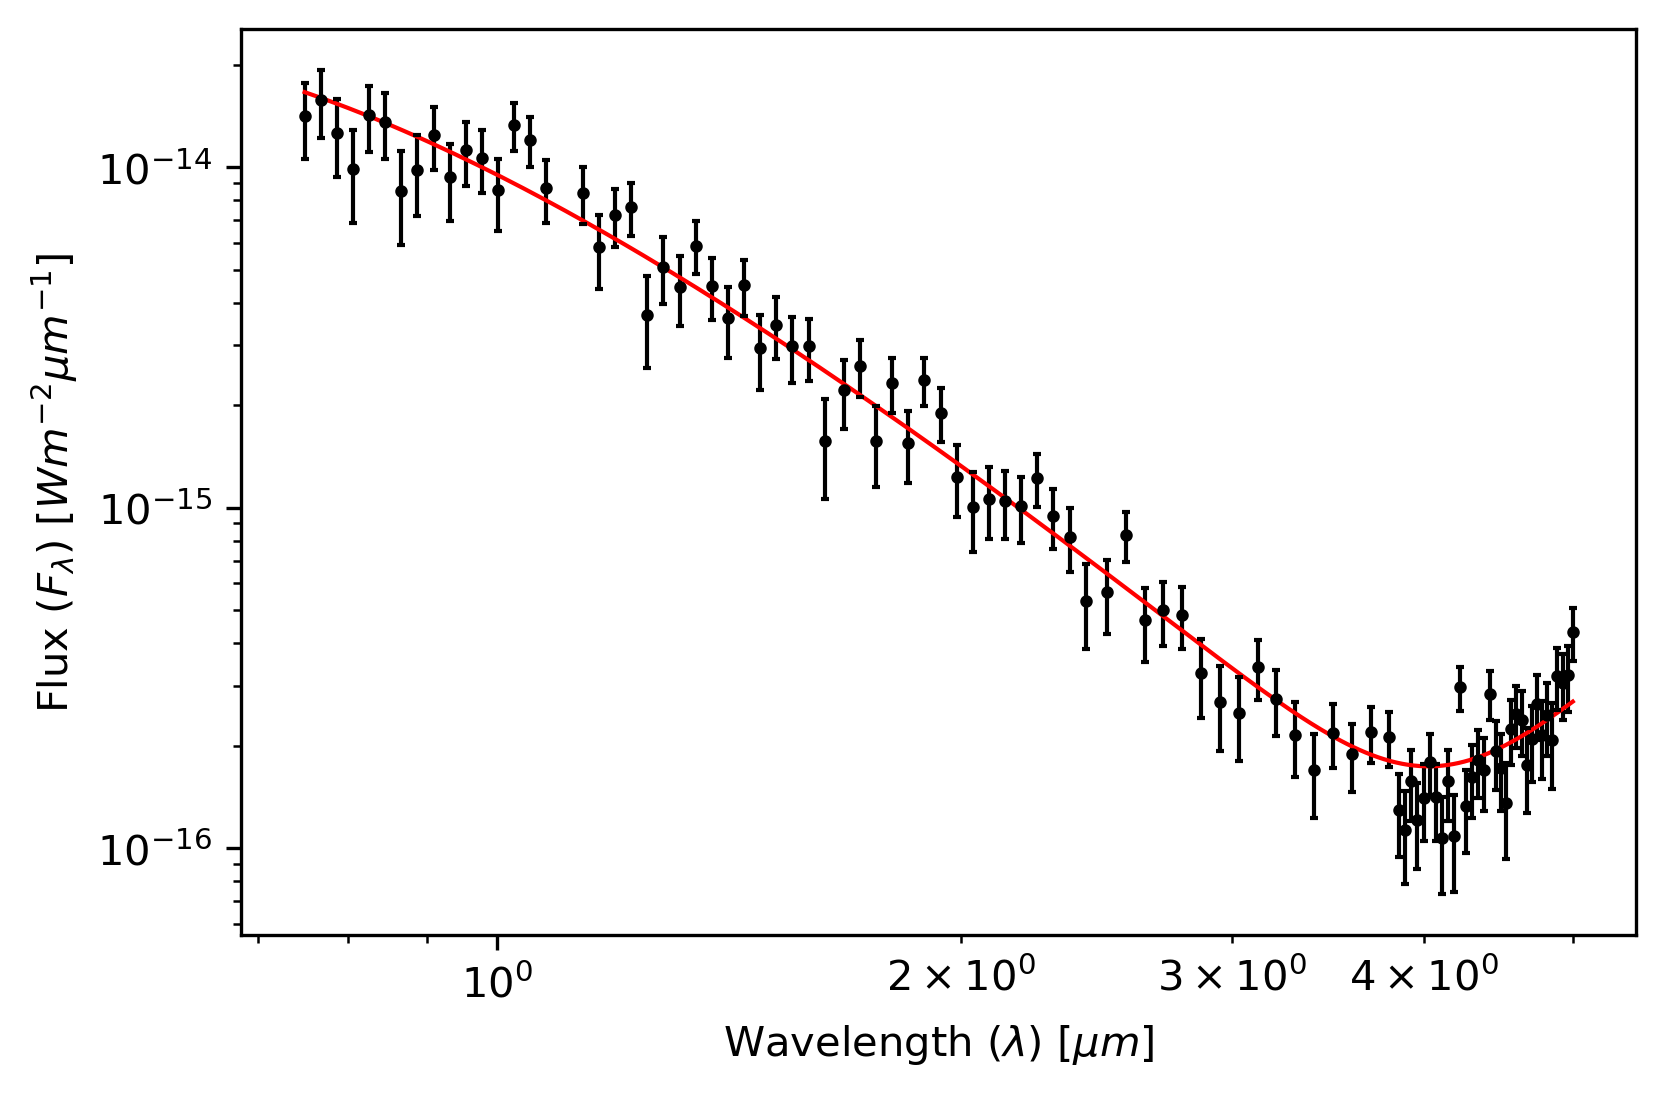

In [16]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
plotSED(
    SED_neatm_fit, 
    ax=ax, 
    plotKwargs={
        "label": "NEATM", 
        "c": "r", 
        "lw": 1
    }
)
plotObservations(
    obs, 
    dataDict[pick_run][pick_asteroid:pick_asteroid+1], 
    ax=ax, 
    columnMapping=columnMapping
)